# Optimization Final Project Analysis and Modeling

### Authors:
<b>Tal Waitzenberg</b> 305578189 <br />
<b>Aviram Hadad</b> (add ID Number)

### Problem

In this project we are facing with the real estate invesments problem in Israel. In israel today there is a variety of people who looking for invest their money in real estate assets. each one of them as a different budget and interests, some of them looking for exists deals (buy in a lower price then market price and immediately sale in market price or higher) or long term invesments and earn from renting the asset. The question that arises is where is the best location and which kind of asset to buy (asset characteristics)?

### Our Approach

After examining several existing academic studies, we developed an approach that believes that Israel has more than one market. Each region/city is divided into several different markets that determined according to the apartment price. 
* how a market is defined?
each market is defined according to apratment characteristics, that can be devided to 2 main categories: <br />
<b>1)</b> numeric features - like apartment size, number of rooms, price <br />
<b>2)</b> categorical features - like if the apratment includes <br />

After spliting the data into markets we want to understand how a price is determined. The price of apartment is determned according to 2 categories: <br />
* house quality characteristics - Variables characterizing the quality of the house, including number of rooms, net house size, house type and house age (The price ration of 2 different apratments will be the change of the quality characteristics between the apratments).
* Environmental characteristics – Variables characterizing the environmental quality of the house, including the socioeconomic level of the area's residents, the proximity to employment centers etc.


We wants to estimate the apartment price according to these categoties and use hedonic regression method which
enables estimating the effect of each unit of a characteristic on the apartment total price.

<br />
In this notebook we are going to implements this 2 approaches we descrive above (markets, hedonic regression)
in offer at the end a good markets for future investment.

In [143]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from scipy.spatial import distance
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import itertools as iter
import locale

Reads Kiryat-Ono apartments history selling data

In [41]:
data = pd.read_csv("./kiryat_ono_data.csv")
data.shape

(1730, 10)

In [42]:
data.dtypes

geo_id                object
sale_date             object
acutal_sale_price     object
sale_value            object
essence               object
sale_percentage      float64
city                  object
construction_year      int64
square_meters          int64
n_rooms              float64
dtype: object

In [43]:
data.head(5)

,geo_id,sale_date,acutal_sale_price,sale_value,essence,sale_percentage,city,construction_year,square_meters,n_rooms
0,006495-0231-000-00,2018-01-23,"3,650,000","3,650,000",cottage tori,1.000,kiryat ono,2011,284,8.0
1,006495-0335-000-00,2018-05-03,"3,575,000","3,575,000",cottage tori,0.374,kiryat ono,1990,240,5.0
2,006491-0106-001-00,2017-10-25,"854,560","854,560",cottage single family,0.200,kiryat ono,0,0,0.0
3,006492-0137-000-00,2019-03-11,"1,500,000","948,000",cottage single family,0.250,kiryat ono,0,0,0.0
4,006492-0196-000-00,2019-07-22,"566,667","566,667",cottage single family,0.083,kiryat ono,0,0,0.0


Checking for emptay or invalid data

In [44]:
# check for data sparse precentage 
data.isnull().sum()

geo_id               0
sale_date            0
acutal_sale_price    0
sale_value           0
essence              0
sale_percentage      0
city                 0
construction_year    0
square_meters        0
n_rooms              0
dtype: int64

There is no empty cells, lets check for zeros

In [45]:
(data == 0).sum()

geo_id                0
sale_date             0
acutal_sale_price     0
sale_value            0
essence               0
sale_percentage       0
city                  0
construction_year    51
square_meters        50
n_rooms              51
dtype: int64

We can see there is a few zeros in 'construction_year', 'square_meters' and 'n_rooms'. its not much so we will delete the rows

In [46]:
data = data[~(data.T == 0).any()]
data.shape

(1679, 10)

Convert 'actual_sale_price', 'sale_value' to ints

In [47]:
locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' )
data['acutal_sale_price'] = data['acutal_sale_price'].apply(lambda x: locale.atoi(x))
data['sale_value'] = data['sale_value'].apply(lambda x: locale.atoi(x))
data.dtypes

geo_id                object
sale_date             object
acutal_sale_price      int64
sale_value             int64
essence               object
sale_percentage      float64
city                  object
construction_year      int64
square_meters          int64
n_rooms              float64
dtype: object

## Markets Clustering

Has we described in our apporoach we want to devide the markets into segments, where each market is different from the other in their house quality characteristics. we dont know how many markets exists so we dont know the value of K (number of clusters). we going to use Kmeans algorithm but we eant to find the optimal number of cluster (the value of K). We going to use a global method to determine the number of clusters, this method called Hartigan's method.Hartigan propsed the folowing index:

<img src="hartigan.png" width=600 height=400/>

* g - number of clusters
* W(g) - the mean distance of all points in a cluster with g clusters
* n - number of points

The smaller the value of W(g) the higher similarity between points in each cluster (with total of g clusters). The idea here is to start with g=1 and increase g by 1 in each iteration if Har(g+1) is significantly large. The stopping criteria is meet, where the stopping criteria is when Har(g) =< 10 (propsed by Hartigan).

We want to use our data for clustering. we need to convert all our features to numeric representation. the 'essence' feature which explain the kund of the aparatment is categorical feature and we going to use one hot encoder to represent this feature in a multiple binary features. we going to do the same for 'construction_year'.

In [72]:
clustering_data = data.copy()
clustering_data = clustering_data.drop('sale_date', axis=1)
clustering_data = clustering_data.drop('city', axis=1)
essence_dummies = pd.get_dummies(data['essence'])
construction_year_dummies = pd.get_dummies(data['construction_year'])
clustering_data = clustering_data.drop('essence', axis=1)
clustering_data = clustering_data.drop('construction_year', axis=1)
clustering_data = pd.concat([clustering_data, construction_year_dummies, essence_dummies], axis=1)
clustering_data = clustering_data.set_index('geo_id')
clustering_data.head(5)

,acutal_sale_price,sale_value,sale_percentage,square_meters,n_rooms,1940,1950,1954,1960,1961,...,2021,2022,building apartment,cottage single family,cottage tori,cottage townhouse,garden apratment,roof apartment,single house,vacation apartment
geo_id,,,,,,,,,,,,,,,,,,,,,
006495-0231-000-00,3650000,3650000,1.000,284,8.0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
006495-0335-000-00,3575000,3575000,0.374,240,5.0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
006492-0262-000-00,1360000,1360000,0.333,145,6.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
006493-0113-000-00,5150000,5150000,1.000,350,8.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
006493-0254-000-00,1542500,1542500,0.250,343,6.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [73]:
clustering_data.shape

(1679, 69)

We got 69 features that we going to use for clustering. We are going to use Kmeans algorithm for clustering and we will use the hartigan metric in order to optimize the number of clusters K. We implemented k_hartigan function that will score every Kmeans estimator, by calculates the centroids in each cluster and the distance from the centroid in each cluster.

In [147]:
def calc_clusters_centroids(data, labels):
    '''
    calculates clusters centers by mean
    '''
    try:
        if isinstance(labels, pd.DataFrame):
            raise Exception('labels should be 1D array')

        if ~isinstance(data, pd.DataFrame):
            data = pd.DataFrame(data)

        labels = pd.DataFrame(labels, columns=['labels'], index=data.index)
        df = pd.concat([data, labels], axis=1)
        centers = pd.DataFrame.groupby(df, by='labels', as_index=True).agg('mean')
        return centers
    except Exception as e:
        print(e)
        raise e
        
    
def calc_points_distances(data, labels, centroids):
    '''
    calc W by the formula:
    W = sum((1/2nr)*sum((Xij - Centroid_i_tagj)^2))
    nr - number of obsevations in cluster
    i - observation
    j - feature in observation
    '''

    try:

        labels_df = pd.DataFrame(labels, columns=['labels'], index=data.index )
        data_copy = data.copy()
        data_copy = pd.concat([data_copy, labels_df], axis=1)
        clusters = pd.DataFrame.groupby(data_copy, by='labels', as_index=True)
        W = sum([(sum(map(lambda r: np.power(distance.euclidean(r[:-1], centroids.loc[label]), 2), Cr.values))) for label, Cr in clusters])
        return np.log1p(W)
    except Exception as e:
        print("Error:",e)
        raise e
        
def k_hartigan(Wks, n_clusters, n_observations, threshold=10):
    '''
    Return optimal K (number of clusters) according to Hartigan score
    '''

    if len(Wks) != len(n_clusters):
        raise Exception('Error: Wks length should be equal to n_clusters')

    try:
        it1, it2 = iter.tee(Wks, 2)
        next(it2, None)
        optimal_k = -1
        for i, (Wk, Wk_plus_1) in enumerate(zip(it1, it2)):
            k = n_clusters[i]
            H = np.multiply(np.true_divide(Wk, Wk_plus_1) - 1, n_observations - k - 1)
            if H < threshold:
                optimal_k = k
                break

        return optimal_k
    except Exception as e:
        print(e)
        raise e

Now we going to run our algorithm and find the best Kmeans algorthm with optimal number of clusterz that will be the number of markets in Kiryat Ono:

In [149]:
wks = []
kmeans_estimator_prev = KMeans(n_clusters=1, random_state=0)
kmeans_estimator_prev.fit(clustering_data.values)
labels_prev = kmeans_estimator_prev.labels_
centroids_prev = calc_clusters_centroids(clustering_data, labels_prev)
wk_prev = calc_points_distances(clustering_data, labels_prev, centroids_prev)
wks.append(wk_prev)
k=2
optimal_k = -1
while True:
    kmeans_estimator_next = KMeans(n_clusters=k, random_state=0)
    kmeans_estimator_next.fit(clustering_data.values)
    labels_next = kmeans_estimator_next.labels_
    centroids_next = calc_clusters_centroids(clustering_data, labels_next)
    wk_next = calc_points_distances(clustering_data, labels_next, centroids_next)
    wks.append(wk_next)
    is_optimal_k = k_hartigan([wk_prev, wk_next], [k-1,k], clustering_data.shape[0])
    
    if is_optimal_k > -1:
        kmeans_best_estimator = kmeans_estimator_prev
        optimal_k = is_optimal_k
        break
        
    k+=1
    kmeans_estimator_prev = kmeans_estimator_next
    wk_prev = wk_next
print("Optimal number of markets %s" % str(optimal_k))

Optimal number of markets 12


Let's plot the mean distances of each run (kmeans where K=1.....12) and to see if the distances got smaller

Text(0.5, 1.0, 'Mean Distances Runs Plot')

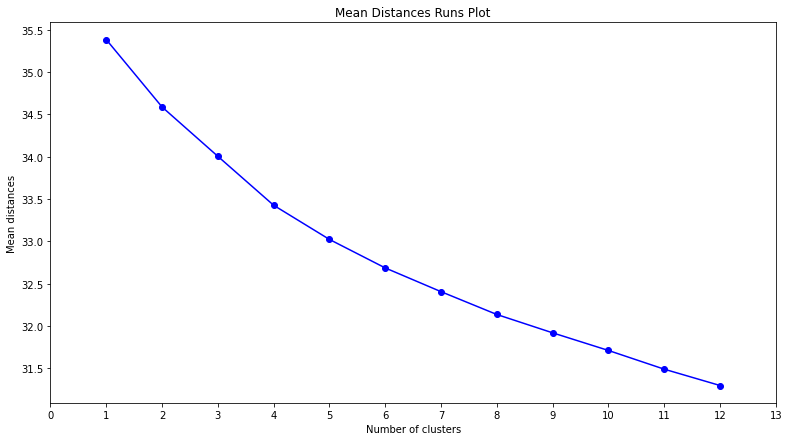

In [153]:
fig, ax = plt.subplots(figsize=(13,7))
x = list(range(1,optimal_k + 1))
y = wks[:-1]
ax.scatter(x, y, color='blue')
ax.plot(x, y, color='blue', linestyle='solid')
ax.set_xticks(np.arange(len(x) + 2))
plt.xlabel('Number of clusters')
plt.ylabel('Mean distances')
plt.title("Mean Distances Runs Plot")

As we cann see the distance went down and the difference ration got smaller and smaller when we reached 12.

We also wants to plot the clusters, In order to plot the best algorithm clusters we need to reduce the number of dimensions. We going to use PCA to reduce the number of dimensions to 3 and plot the cluster on 3D plot.

In [156]:
def plot_3d_scatter(data,labels):
    fig1 = plt.figure(figsize=(13,7))
    ax1 = Axes3D(fig1)
    ax1.scatter(data[:,1], data[:,0], data[:,2],c=labels)

    fig2 = plt.figure(figsize=(13,7))
    ax2 = Axes3D(fig2)
    ax2.scatter(data[:,0], data[:,1], data[:,2],c=labels)

    plt.show()

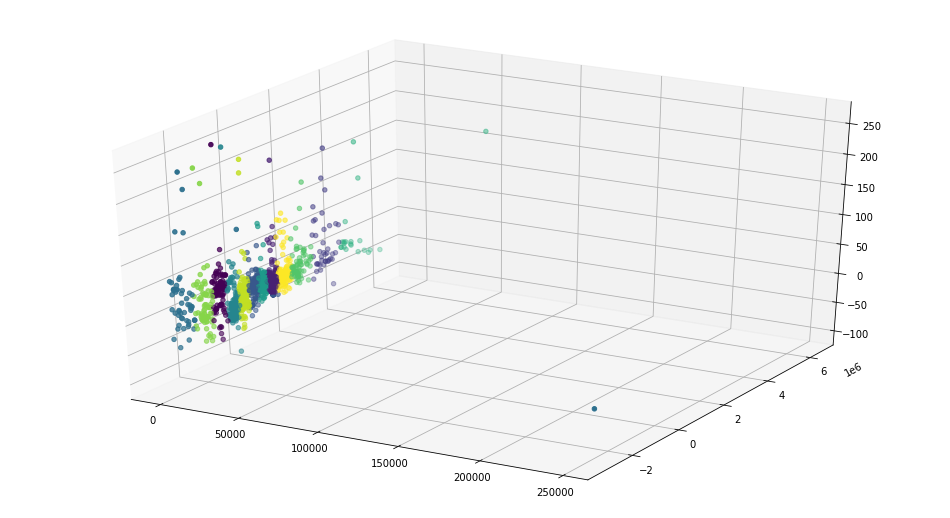

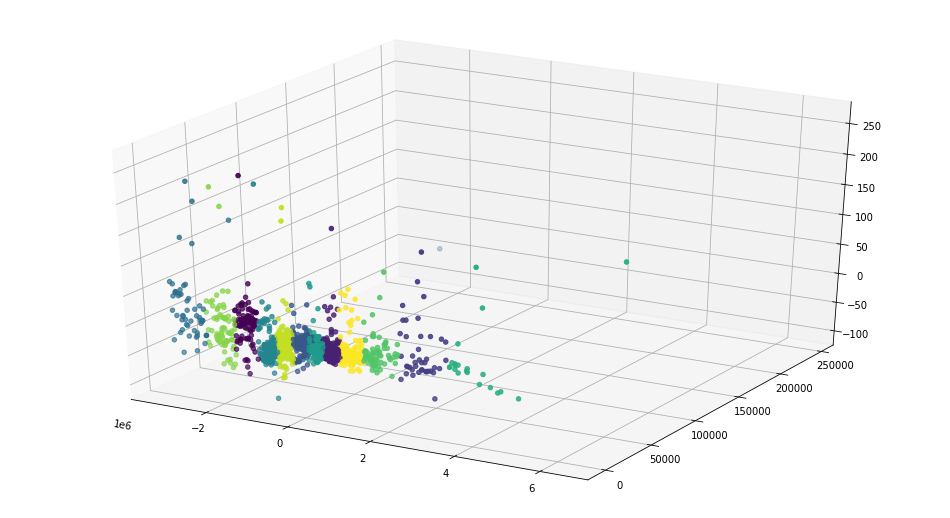

In [157]:
# perform PCA for plotting
kmeans_pca = PCA(n_components=3)
kmeans_pca_data = kmeans_pca.fit_transform(clustering_data)

# plot 3D scatter
plot_3d_scatter(kmeans_pca_data,kmeans_best_estimator.labels_)

As we can see we got 12 clusters, some of them really dense and some of the are less. it can point that there is some really simillar apartments in the data that are the majority in the market and there some apartments that are more rare and different than others (like penthouses, Vilas etc).

## Prices Hedonic Regression